In [4]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy import fft

In [8]:
df = pd.read_csv('../regularset.csv')
df = df.drop([0])

In [9]:
# parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))

In [10]:
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [19]:
# initializes ff model
def init_model(L, zero_pad = False):
    model = tf.keras.Sequential()

    if zero_pad:
        model.add(tf.keras.layers.InputLayer(input_shape=(841,))) # shape is the size of our L box
    else:
    # Add the input layer (implicitly defined by the first layer)
        model.add(tf.keras.layers.InputLayer(input_shape=((((L*2)+1)**2),))) # shape is the size of our L box
    
    # Add the output layer with Y units (no activation for regression, 'softmax' or 'sigmoid' for classification)
    model.add(tf.keras.layers.Dense(841))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001) # should likely change/test optimizer to ADAM
    
    model.compile(optimizer=optimizer, loss='mse')  # or 'categorical_crossentropy' for classification
    return model

In [16]:
# Function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# Apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft '].apply(split_dft))

In [34]:

df['dft_combined'] = df['dft_real'] + df['dft_imag'] * 1j

L = 5
df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))
df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))
df['L'] = df.apply(combine_real_imag, axis=1)
# print(df['L'][0])
df['L_complex'] = df['L'].apply(lambda x: np.array([real + comp * 1j for real, comp in x.reshape(841,2)]).reshape(29,29))
df['L_rolled'] = df['L_complex'].apply(lambda x: np.roll(x.reshape(29,29), shift=(-14, -14), axis=(0, 1)))
df['ift'] = df['L_rolled'].apply((lambda x: fft.ifft2(x.reshape(29,29)).real.flatten()))


                                     

In [42]:
arrays = np.stack(df['code_array'].values)
average_array = np.mean(arrays, axis=0)

fixedIndx = []
for i in range(29):
    for j in range(29):
        if average_array[i][j] == 1 or average_array[i][j] == 0:
            fixedIndx.append((i, j))

In [36]:
#take in full size 1d array,reshape it to original 29 by 29, and shift it so center is in right place
# df['dft_rolled'] = df['dft'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))

In [37]:
y = np.stack(df['code_oned'].values)  # Shape: (num_samples, 29,29)

In [29]:
# function to take in array and get L matrix

def get_centered_subarray(array, L, zero_pad=False):
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    array = array[start:end, start:end]
    if zero_pad:
        var_index = 14 - L
        array = np.pad(array, var_index, 'constant')
    return array

In [35]:
# Define a function to combine real and imaginary parts
def combine_real_imag(row):
    # Stack along the last axis to create a new dimension for channels
    combined = np.stack((row['L_real'], row['L_imag']), axis=-1)
    return combined  # Shape: (L, L, 2)

In [40]:
def evaluate_model(model, X, y, num_samples=999):
    #Takes in trained model, input data, correct output data, and number of samples to compute for based on validation set
    #outputs the accuracy of the predicted pixels
    # Ensure num_samples does not exceed the available samples
    num_samples = min(num_samples, X.shape[0])
    
    # Predict the QR codes
    y_pred = model.predict(X[:num_samples])
    
    # Check if the shapes match
    if y_pred.shape != y[:num_samples].shape:
        # If y_pred is (num_samples, 29, 29, 1) and y is (num_samples, 29, 29, 1), it's okay
        # Otherwise, attempt to reshape if possible
        try:
            y_pred = y_pred.reshape(y[:num_samples].shape)
        except:
            raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} vs y shape {y[:num_samples].shape}")
    
    # Apply a threshold to convert predictions to binary
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate pixel-wise accuracy
    correct_pixels = (y_pred_binary == y[:num_samples]).astype(int)
    pixel_accuracy = correct_pixels.mean()
    
    return pixel_accuracy

In [27]:
def evaluate_model_blur(X, y, num_samples=999):
    """
    Evaluates the pixel-wise accuracy of blurred QR codes (X) vs ground truth (y).
    X and y are columns from a DataFrame where each entry is a 1D array.
    """
    # Convert to stacked numpy arrays
    if isinstance(X, pd.Series):
        X = np.stack(X.values)
    if isinstance(y, pd.Series):
        y = np.stack(y.values)

    # Limit to available samples
    num_samples = min(num_samples, X.shape[0], y.shape[0])
    y_pred = X[:num_samples]
    y_true = y[:num_samples]

    # Ensure shapes match
    if y_pred.shape != y_true.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} vs y_true shape {y_true.shape}")

    # Binarize predictions
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Compute pixel-wise accuracy
    correct = (y_pred_binary == y_true).astype(int)
    pixel_accuracy = correct.mean()

    return pixel_accuracy



In [36]:
print(evaluate_model_blur(df['ift'], df['code_oned']))

0.6323148356442054


In [41]:
def evaluate_fixed(model, X, y, num_samples=999):
    #Takes in trained model, input data, correct output data, and number of samples to compute for based on validation set
    #outputs the accuracy of the predicted pixels
    # Ensure num_samples does not exceed the available samples
    num_samples = min(num_samples, X.shape[0])
    
    # Predict the QR codes
    y_pred = model.predict(X[:num_samples])
    
    # Check if the shapes match
    if y_pred.shape != y[:num_samples].shape:
        # If y_pred is (num_samples, 29, 29, 1) and y is (num_samples, 29, 29, 1), it's okay
        # Otherwise, attempt to reshape if possible
        try:
            y_pred = y_pred.reshape(y[:num_samples].shape)
        except:
            raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} vs y shape {y[:num_samples].shape}")
    
    # Apply a threshold to convert predictions to binary
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate pixel-wise accuracy
    correct_pixels = 0
    for pred, correct in zip(y_pred_binary, y[:num_samples].astype(int)):
        for i,j in fixedIndx:
            if pred[i][j] == correct[i][j]:
                correct_pixels += 1
    pixel_accuracy = correct_pixels / (len(fixedIndx) * num_samples)
    return pixel_accuracy

In [ ]:
#loop to train model for different L sizes. use this loop for convo.

#stat stores L size with accuracy for plotting after
stat = []
for L in [10, 9, 8, 7, 6, 5]:
    #get L matrices flattened
    
    # CLEAN THIS UP LOL
    df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))
    df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))

    # Apply the function to each row to create the 'L_combined' column
    df['L'] = df.apply(combine_real_imag, axis=1)
    # print(df['L'][0])
    df['L_complex'] = df['L'].apply(lambda x: np.array([real + comp * 1j for real, comp in x.reshape(841,2)]).reshape(29,29))
    df['L_rolled'] = df['L_complex'].apply(lambda x: np.roll(x.reshape(29,29), shift=(-14, -14), axis=(0, 1)))
    df['ift'] = df['L_rolled'].apply((lambda x: fft.ifft2(x.reshape(29,29)).real.flatten()))
    # diagnostic print
    # print(df['L'][0].shape)
    #concatenate imag and real 1d arrays
    model = init_model(L, zero_pad=True)
    # Features (X) - DFT components
    X = np.stack(df['ift'].values)  
    # print(X.shape)
    # Split the data into training and testing sets
    #y sets should be initialized outside loop since they don't change
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Fit the model
    model.fit(X_train, y_train, epochs=100, validation_data=[X_test[1000:], y_test[1000:]])

    #eval model
    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    stat.append((L, accuracy))

    print(stat)

In [ ]:
min(np.stack(df['ift'].values).flatten())

-0.8838603005420527

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L value', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L  

In [ ]:
fig.savefig('50_epoch_1convo_8filters_adam_LR001.png', dpi=300)

In [26]:
stat

[(10, 0.6789536266349584),
 (9, 0.6837098692033293),
 (8, 0.7086801426872771),
 (7, 0.7074910820451843),
 (6, 0.6872770511296076),
 (5, 0.6825208085612366)]

In [46]:
#Epoch loop

# Set L to 10 and initialize stat to store accuracy at specified epoch intervals
L = 10
stat = []

df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))
df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L, zero_pad=True))

# Apply the function to each row to create the 'L_combined' column
df['L'] = df.apply(combine_real_imag, axis=1)
# print(df['L'][0])
df['L_complex'] = df['L'].apply(lambda x: np.array([real + comp * 1j for real, comp in x.reshape(841,2)]).reshape(29,29))
df['L_rolled'] = df['L_complex'].apply(lambda x: np.roll(x.reshape(29,29), shift=(-14, -14), axis=(0, 1)))
df['ift'] = df['L_rolled'].apply((lambda x: fft.ifft2(x.reshape(29,29)).real.flatten(v m, ,njjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbknm                    bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbvvvvvvvvvvvvvjkh
L>'# Initialize the convolutional model
model = init_model(L, zero_pad=True)

# Features (X) - DFT components
X = np.stack(df['ift'].values)
# Assuming y is already initialized outside the loop
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify epoch intervals to record accuracy
epoch_intervals = [25, 50, 75, 100, 125, 150, 175,200]
current_epoch = 0

# Training in intervals and recording accuracy
for epochs in epoch_intervals:
    # Train the model from the current epoch to the next interval
    

    model.fit(X_train, y_train, initial_epoch=current_epoch, epochs=epochs, validation_data=(X_test[1000:], y_test[1000:]))
    current_epoch = epochs  # Update the current epoch to the last trained epoch

    # Evaluate the model and record accuracy
    accuracy = evaluate_model(model, X_test[:999], y_test[:999])
    fixed_accuracy = evaluate_fixed(model, X_test[:999], y_test[:999])
    
    stat.append((epochs, accuracy, fixed_accuracy))

    # Print or log the current status
    print(f"Epochs: {epochs}, Accuracy: {accuracy}, Fixed Accuracy: {fixed_accuracy}")

print("Final stat:", stat)


Epoch 1/25
250/250 [==============================] - 4s 13ms/step - loss: 0.8123 - val_loss: 0.7327
Epoch 2/25
250/250 [==============================] - 2s 8ms/step - loss: 0.6683 - val_loss: 0.6090
Epoch 3/25
250/250 [==============================] - 2s 8ms/step - loss: 0.5611 - val_loss: 0.5170
Epoch 4/25
250/250 [==============================] - 2s 7ms/step - loss: 0.4814 - val_loss: 0.4486
Epoch 5/25
250/250 [==============================] - 2s 7ms/step - loss: 0.4221 - val_loss: 0.3976
Epoch 6/25
250/250 [==============================] - 2s 7ms/step - loss: 0.3779 - val_loss: 0.3597
Epoch 7/25
250/250 [==============================] - 2s 8ms/step - loss: 0.3450 - val_loss: 0.3314
Epoch 8/25
250/250 [==============================] - 2s 6ms/step - loss: 0.3205 - val_loss: 0.3104
Epoch 9/25
250/250 [==============================] - 2s 6ms/step - loss: 0.3023 - val_loss: 0.2947
Epoch 10/25
250/250 [==============================] - 2s 7ms/step - loss: 0.2886 - val_loss: 0.283

IndexError: invalid index to scalar variable.

In [ ]:
stat

[(50, 0.8680142687277052),
 (75, 0.8739595719381689),
 (100, 0.8810939357907254),
 (125, 0.8775267538644471),
 (150, 0.8799048751486326),
 (175, 0.8799048751486326),
 (200, 0.8787158145065398)]

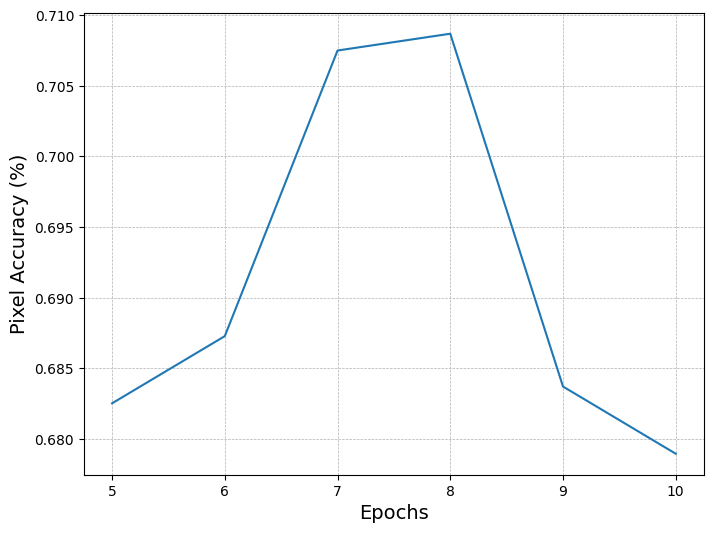

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L  

In [ ]:
fig.savefig('L10_1convo_8filters_adam_LRScheduler.png', dpi=300)

In [38]:
stat = [(10, 0.6789536266349584),
 (9, 0.6837098692033293),
 (8, 0.7086801426872771),
 (7, 0.7074910820451843),
 (6, 0.6872770511296076),
 (5, 0.6825208085612366)]